# Hello variational AutoEncoder for FMNIST dataset

In [1]:
# Prerequisites
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf


print("Python Version: ", sys.version)
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)
print("TensorFlow Version: ", tf.__version__)

2025-04-01 11:59:50.006979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743533990.025361 2414215 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743533990.031301 2414215 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743533990.046416 2414215 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743533990.046434 2414215 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743533990.046436 2414215 computation_placer.cc:177] computation placer alr

Python Version:  3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
Numpy Version:  2.1.3
Pandas Version:  2.2.3
TensorFlow Version:  2.19.0


The latest TensorFlow is based on Keras 3. Not everything needed for this sample is implemented in Keras 3, so need to revert back to Keras 2.  To use Keras 2.*, do the following:

- Import the `tf_keras` package.
- Set the `TF_USE_LEGACY_KERAS` environment variable to `"1"` 

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1" 

import tf_keras
print("tf_keras version:", tf_keras.__version__)

tf_keras version: 2.19.0


Check for GPU presence

In [3]:
if tf.config.list_physical_devices('GPU'):
    print("GPU detected")
else:
    print("No GPU Detected")

GPU detected


### Get Fashion MNIST Dataset

In [4]:
# Get dataset and split into training, validation, and test sets
f_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = f_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

### Build and train the Variational AutoEncoder

Custom layer for sampling the codings

In [5]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

Define encoder and decoder using Keras Functional API

In [6]:
tf.random.set_seed(42)

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
ae_variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
         

I0000 00:00:1743534388.276249 2414215 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8885 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:04:00.0, compute capability: 7.0


In [7]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
ae_variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [8]:
_, _, codings = ae_variational_encoder(inputs)
reconstructions = ae_variational_decoder(codings)
ae_variational = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [9]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1)
ae_variational.add_loss(tf.reduce_mean(latent_loss) / 784.)

ae_variational.compile(loss="mse", optimizer="nadam")

In [10]:
# Note X_train used for both inputs and targets, same for validation data
history = ae_variational.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_val, X_val))    

Epoch 1/25


I0000 00:00:1743534402.073123 2414598 service.cc:152] XLA service 0x795f1ced34e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743534402.073142 2414598 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2025-04-01 12:06:42.086273: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743534402.096494 2414598 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1743534402.206136 2414598 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


430/430 [==============================] - 5s 4ms/step - loss: 0.0513 - val_loss: 0.0387
Epoch 2/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0366 - val_loss: 0.0355
Epoch 3/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0346 - val_loss: 0.0344
Epoch 4/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0337 - val_loss: 0.0336
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.0331 - val_loss: 0.0332
Epoch 6/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0328 - val_loss: 0.0329
Epoch 7/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0325 - val_loss: 0.0327
Epoch 8/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0322 - val_loss: 0.0327
Epoch 9/25
430/430 [==============================] - 1s 3ms/step - loss: 0.0321 - val_loss: 0.0325
Epoch 10/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0319 - val_loss: 0.0321
Epoch 11/2

In [11]:
ae_variational.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 model (Functional)          [(None, 10),                 134870    ['input_1[0][0]']             
                              (None, 10),                                                         
                              (None, 10)]                                                         
                                                                                                  
 model_1 (Functional)        (None, 28, 28)               134634    ['model[0][2]']               
                                                                                            

### Visualize Reconstruction from dropout images

1/1 [==============================] - 0s 99ms/step


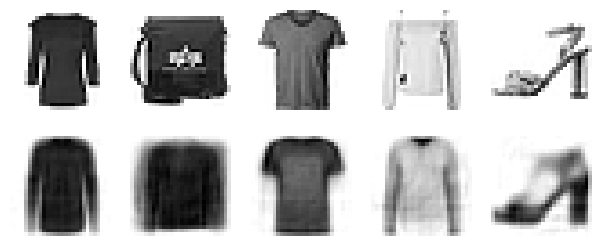

In [12]:
def viz_reconstructions(model, images=X_val, n_images=5):
    reconstruct = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstruct[image_index], cmap="binary")
        plt.axis("off")

viz_reconstructions(ae_variational)
plt.show()

In [13]:
codings = tf.random.normal(shape=[3 * 7, codings_size])
images = ae_variational_decoder(codings).numpy()

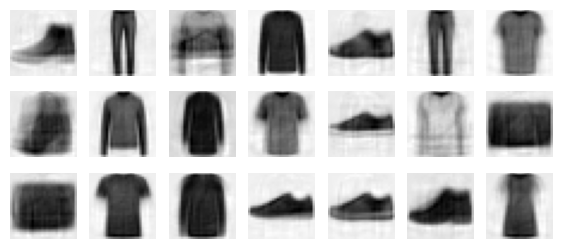

In [14]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.show()